In [1]:
import numpy as np 
from astropy import constants as c
from scipy.integrate import quad 
import os
import h5py
import matplotlib.pyplot as plt
import sympy as smp
from mpl_toolkits import mplot3d

In [2]:
def phi_0(k: np.array) -> float:
    k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
    # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
    # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val



def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
    test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, epsabs=1e-3, full_output=False)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    

### Standard values

In [6]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_400 = w_800 * 800 / 400
w_s = w_400

A_0_s = F_0 / w_400

E_0_s = -13.6 / conversion_ev_au

N_s = 5
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 0.5

### Calculate the two (three) tedious (easy) integrals 

t, T, w, p = smp.symbols('t, T, w, p', real=True, positive=True)

### A(t)**2

func_sin4sin2 = (smp.sin(smp.pi * t / T)**2 * smp.sin(w * t + p))**2
func_sin4sin2

int_sin4sin2 = smp.integrate(func_sin4sin2, (t, 0, t))

simple_int_sin4sin2 = int_sin4sin2.simplify()

### To showcase that simplifying saves time 

test_time = 50

%time
simple_int_sin4sin2.subs({t: test_time, w: w_s, p: phase_s, T: T_s}).evalf()

%time
int_sin4sin2.subs({t: test_time, w: w_s, p: phase_s, T: T_s}).evalf()

## Which results is correct ? 

test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2

%time
num_sin4cos2 = quad(test_sin4cos2, 0, 3, epsabs=1e-3, full_output=False)
num_sin4cos2

num_sin4cos2

func_sin4cos2 = (smp.sin(smp.pi * t / T)**2 * smp.cos(w * t + p))**2
func_sin4cos2

int_sin4cos2 = smp.integrate(func_sin4cos2, (t, 0, t))

simple_int_sin4cos2 = int_sin4cos2.simplify()

simple_int_sin4cos2

### kA(t)

func_sin2cos = smp.sin(smp.pi * t / T)**2 * smp.cos(w * t + p)
func_sin2cos

int_sin2cos = smp.integrate(func_sin2cos, (t, 0, t))

simple_int_sin2cos = int_sin2cos.simplify()

simple_int_sin2cos

func_sin2sin = smp.sin(smp.pi * t / T)**2 * smp.sin(w * t + p)
func_sin2sin

int_sin2sin = smp.integrate(func_sin2sin, (t, 0, t))

simple_int_sin2sin = int_sin2sin.simplify()

simple_int_sin2sin

### Testing 

# Evaluate all funcs before running 
test_e_sin4sin2 = simple_int_sin4sin2.subs({w: w_s, p: phase_s, T: T_s}).evalf()
test_e_sin4cos2 = simple_int_sin4cos2.subs({w: w_s, p: phase_s, T: T_s}).evalf()
test_e_sin2sin = simple_int_sin2sin.subs({w: w_s, p: phase_s, T: T_s}).evalf()
test_e_sin2cos = simple_int_sin2cos.subs({w: w_s, p: phase_s, T: T_s}).evalf()

In [7]:
k_test = np.array([1, 1, 0])

M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
<ipython-input-2-38dd0326f361>:64: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False)
<ipython-input-2-38dd0326f361>:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to 

-3.508321763574689e-07j

In [9]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]

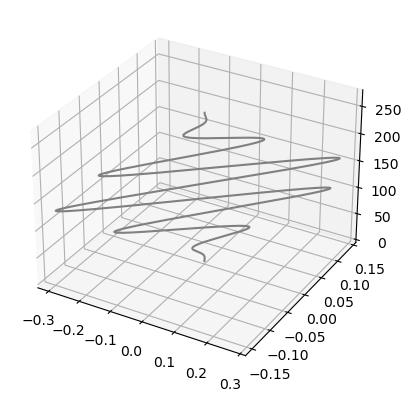

In [10]:
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [14]:
length = 10
start_val = -10
end_val = 10
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)

kx_plot = []
ky_plot = []
values_plot = []
for i, kx in enumerate(kxs):
    values = [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]
    print(i)
    kx_plot.extend(kx * np.ones(length))
    ky_plot.extend(kys)
    values_plot.extend(values)
        

<ipython-input-2-38dd0326f361>:64: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False)
<ipython-input-2-38dd0326f361>:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  P

0
1


KeyboardInterrupt: 

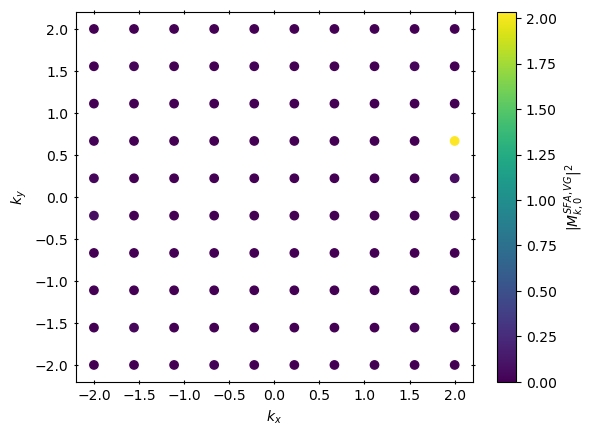

In [12]:
# Lav et farvekodet plot
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot)

# Vend akserne (det er et Kiel diagram), sæt ticks korrekt og titler på
ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

# Indsæt colorbar så man kan se hvad der foregår
fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
fig

In [13]:
A_0

NameError: name 'A_0' is not defined